<a href="https://colab.research.google.com/github/sjbaek12/sjbaek12.github.io/blob/master/%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def env():
  price=[]
  for i in range(10):
    bias = np.random.rand(1)
    p = -0.01*(i-50)**2 + bias*10
    price.append(p[0])
  p_mean = np.mean(price)
  p_std = np.std(price)
  price = (price - p_mean)/p_std
  return price

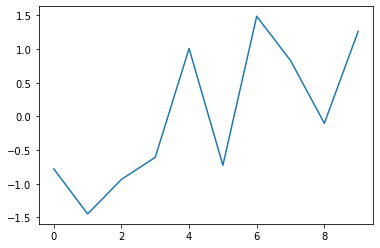

In [3]:
# 환경함수를 통해서 하나의 시장 환경을 만들었다.

price = env()
plt.plot(price)
plt.show()

In [4]:
multip = np.array([2.0, 100.0, 5.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

In [5]:
# 랜덤하게 행동들을 만들어낸다. 사실 이건 필요하지 않다.

def act():
  actions = []
  for i in range(10):
    if np.random.rand() > 0.5:
      act = 1
    else:
      act = 0
    actions.append(act)
  return actions

In [6]:
y = act() # 1은 buy, 0는 sell로 표시한다.
print(y)

[0, 0, 0, 0, 0, 1, 0, 1, 1, 0]


In [7]:
import tensorflow as tf
y_encoded = tf.keras.utils.to_categorical(y) # softmax를 사용하려면 출력 unit이 여러개이기 때문에 그것에 맞추어 y값을 변경하여야 한다.

In [8]:
y_encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

custom loss 함수를 테스트 해본다.

In [9]:
import keras.layers as layers
from keras.layers import LSTM, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

Using TensorFlow backend.


In [10]:
def my_loss(y_true, y_pred):
  y_true = y_true **2
  y_pred = y_pred **2
  loss = K.mean(K.abs(y_true - y_pred) + K.square(y_true - y_pred))
  return loss * multip



def my_metric(y_true, y_pred):
  return K.mean(K.abs(y_true - y_pred)) * 1000

In [11]:
def get_policy_model():
  inp = layers.Input(shape=(1,),name="input_x")
  multip = layers.Input(shape=[1], name="advantages") # [1]의 대안 (1,) 이다
  x = layers.Dense(4, activation="relu", name="dense_1")(inp)
  output = layers.Dense(2, activation="softmax", name="out")(x)
  model_train = Model(inputs=[inp, multip], outputs = output)

  def custom_loss(y_true, y_pred):
    # actual: 0 predict: 0 -> log(0 * (0 - 0) + (1 - 0) * (0 + 0)) = -inf
    # actual: 1 predict: 1 -> log(1 * (1 - 1) + (1 - 1) * (1 + 1)) = -inf
    # actual: 1 predict: 0 -> log(1 * (1 - 0) + (1 - 1) * (1 + 0)) = 0
    # actual: 0 predict: 1 -> log(0 * (0 - 1) + (1 - 0) * (0 + 1)) = 0
   log_lik = K.log(y_true * (y_true - y_pred) + (1 - y_true) * (y_true + y_pred))
   return K.mean(log_lik * multip, keepdims=True)

  model_train.compile(optimizer='adam', loss=custom_loss, metrics=[my_metric])
  model_predict = Model(inputs=[inp], outputs = output)
  return model_train, model_predict

In [12]:
model_train, model_predict = get_policy_model()

In [13]:
model_train.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 8         
_________________________________________________________________
out (Dense)                  (None, 2)                 10        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_train.fit([price, multip], y_encoded, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 28ms/step - loss: -8.1935 - my_metric: 539.8262
Epoch 2/10
10/10 [==============================] - 0s 623us/step - loss: -8.2153 - my_metric: 539.1978
Epoch 3/10
10/10 [==============================] - 0s 473us/step - loss: -8.2372 - my_metric: 538.5688
Epoch 4/10
10/10 [==============================] - 0s 190us/step - loss: -8.2591 - my_metric: 537.9394
Epoch 5/10
10/10 [==============================] - 0s 230us/step - loss: -8.2797 - my_metric: 537.3480
Epoch 6/10
10/10 [==============================] - 0s 222us/step - loss: -8.3018 - my_metric: 536.7175
Epoch 7/10
10/10 [==============================] - 0s 449us/step - loss: -8.3239 - my_metric: 536.0864
Epoch 8/10
10/10 [==============================] - 0s 277us/step - loss: -8.3461 - my_metric: 535.4547
Epoch 9/10
10/10 [==============================] - 0s 171us/step - loss: -8.3683 - my_metric: 534.8223
Epoch 10/10
10/10 [==============================] - 0s 213us/ste

In [14]:
f = model_predict.predict(price)
print(f)

[[0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.3189345  0.6810655 ]
 [0.45622513 0.54377484]
 [0.43916774 0.56083226]
 [0.32051426 0.67948574]
 [0.5        0.5       ]
 [0.16419162 0.83580846]]


In [14]:
def discount_rewards(r, gamma=0.99):
    """Takes 1d float array of rewards and computes discounted reward
    e.g. f([1, 1, 1], 0.99) -> [2.9701, 1.99, 1]
    """
    prior = 0
    out = []
    r = r[::-1]
    for val in r:
        new_val = val + prior * gamma
        out.append(new_val)
        prior = new_val
    return np.array(out[::-1])

In [15]:
def reward (price, action):
  reward =[0]
  for i in range(0, len(price)-1):
    price_gap = price[i+1]- price[i]
    if price_gap > 0 and action[i] == 1 :
       reward.append(1)
    if price_gap > 0 and action[i] == 0 :
       reward.append(-1)
    if price_gap < 0 and action[i] == 1 :
       reward.append(-1)
    if price_gap < 0 and action[i] == 0 :
       reward.append(1)
  return reward

In [16]:
# test_set에 적용하는 함수

def score_model(model_predict, num_tests):
    scores = []    
    for num_test in range(num_tests):
        observation = env()
        forcasts = model_predict.predict(observation)
        rw = reward(observation, np.argmax(forcasts, axis=1))
        reward_sum = np.sum(rw)
        scores.append(reward_sum)
    return np.mean(scores)

In [18]:
hit = score_model(model_predict, 100)
print(hit)

-3.56


In [17]:
## 여기부터 재작성

reward_sum = 0
num_actions = 2
dimen = 10
batch_size = 5

# Placeholders for our observations, outputs and rewards
states = np.empty(0).reshape(0,dimen)
actions = np.empty(0).reshape(0,dimen)
rewards = np.empty(0).reshape(0,dimen)
discounted_rewards = np.empty(0).reshape(0,dimen)

# Setting up our environment
state = env() # 한개의 state를 발생시킨다.

num_episode = 0
num_episodes = 500

losses = []

while num_episode < num_episodes:
    
    predict = model_predict.predict(state)  # 한개의 state를 input해서 신경망을 통해 action을 만들어낸다.
    
    #print(predict)

    acts = []
    for i in range(0, len(predict)):
      action = np.random.choice(range(num_actions),p=predict[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
      acts.append(action)

    #print(acts)

    e_r = reward(state, acts)



    # Append the observations and outputs for learning
    states = np.vstack([states, state]) # 미리 만들어 놓은 placeholder인 states에 while문 밖에서 만들어낸 state를 append 시키다.
    actions = np.vstack([actions, acts]) # 동일하게 state가 입력이 되어서 신경망이 산출한 행동을 확율적으로 선택한 행동을 actions에 append한다.

    #print(actions)

    rewards = np.vstack([rewards, e_r])

    #print(rewards)

    if np.sum(e_r) > 8 or len(states) >= 20:
      # Determine standardized rewards
      for i in range(0, len(rewards)-1):
        discounted_rewards_episode = discount_rewards(rewards[i], gamma=0.99)
        discounted_rewards = np.vstack([discounted_rewards, discounted_rewards_episode])

      

      for i in range(0, len(discounted_rewards)-1):  
        discounted_rewards[i] -= discounted_rewards[i].mean()
        discounted_rewards[i] /= discounted_rewards[i].std()
        discounted_rewards = discounted_rewards.squeeze()

            
      actions = actions.squeeze().astype(int)  # squeeze 함수는 배열에서 차원이 1인 것을 찾아서 없애버린다. 예) (2,2,1) --> (2,2)
   

      y_target = []
      for i in range(0, len(actions)-1):
        actions_train = np.zeros([len(actions[i]), num_actions])
        actions_train[np.arange(len(actions[i])), actions[i]] = 1
        y_target.append(actions_train)



      for i in range(0, len(states)-1):
        loss = model_train.train_on_batch([states[i], discounted_rewards[i]], y_target[i])
        losses.append(loss)
        hit = score_model(model_predict, 100)

      print(losses, "score is:", hit)

      #hit = score_model(model_predict, 100)
      #print(hit)

            
      states = np.empty(0).reshape(0,dimen)
      actions = np.empty(0).reshape(0,dimen)
      rewards = np.empty(0).reshape(0,dimen)
      discounted_rewards = np.empty(0).reshape(0,dimen)

    num_episode += 1


[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498]] score is: 3.54
[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498], [-0.08437457, 480.33896], [-0.012353575, 484.61636], [0.006205964, 560.36475], [-0.19773993, 422.5599], [0.005452824, 413.22583], [-0.10748787, 452.38953], [-0.10706987, 464.27267], [-0.22374515, 433.20386], [-0.123715356, 413.9975], [-0.03620839, 423.74664], [-0.15655065, 474.16736], [-0.09205987, 481.48737], [-0.2051022, 389.10062], [-0.11515021, 530.37274], [-0.22005029, 420.79654], [-0.21384712, 409.01703], [-0.15261897, 465.4117], [-0.19413432, 406.67566], [-0.35986453, 434.7005]] score is: 3.82
[[-0.17134354, 424.02673], [-0.17666495, 402.87653], [-0.17286736, 473.20026], [-0.20000513, 425.26587], [-0.4921371, 447.9498], [-0.08437457, 480.33896], [-0.012353575, 484.61636], [0.006205964, 560.36475], [-0.19773993,

KeyboardInterrupt: ignored

In [ ]:


        # Print periodically
        if (num_episode + 1) % print_every == 0:
            # Print status
            score = score_model(model_predict,10)
            print("Average reward for training episode {}: {:0.2f} Test Score: {:0.2f} Loss: {:0.6f} ".format(
                (num_episode + 1), reward_sum/print_every, 
                score,
                np.mean(losses[-print_every:])))
            
            if score >= goal:
                print("Solved in {} episodes!".format(num_episode))
                break
            reward_sum = 0
                
        num_episode += 1
        observation = env.reset()

In [ ]:
states = np.empty(0).reshape(0,10)
observation = env()
state = observation
states = np.vstack([states, state])
print(states)

[[-2.14444758 -0.44786527  0.27428755 -1.35549211  0.21041568  0.58894521
   0.73969842  0.03003539  1.31171488  0.79270784]]


In [ ]:
states

array([[-2.14444758, -0.44786527,  0.27428755, -1.35549211,  0.21041568,
         0.58894521,  0.73969842,  0.03003539,  1.31171488,  0.79270784]])

In [ ]:
acts=[]
for i in range(0, len(f)):
  action = np.random.choice(range(2),p=f[i]) # 대안 중에서 하나를 선택한다. p=[0.4, 0.6] 대안이 선택될 확율이다. action은 0 또는 1 이된다.
  acts.append(action) 

In [ ]:
acts

[0, 1, 0, 0, 1, 1, 1, 0, 1, 0]

In [ ]:
actions = np.empty(0).reshape(0,dimen)

In [ ]:
actions = np.vstack([actions, acts])

In [ ]:
actions

array([[0., 1., 0., 0., 1., 1., 1., 0., 1., 0.]])

In [ ]:
actions = actions.squeeze().astype(int)

In [ ]:
actions

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
actions_train = np.zeros([len(actions), 2])


In [ ]:
actions_train

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
actions_train[np.arange(len(actions)), actions] = 1

In [ ]:
actions_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [ ]:
for i in range(len(states)):
  print(reward(states[i], actions[i]))

[-1, 1, -1, 1, 1, 1, 1, -1, -1]


In [ ]:
len(actions)

1

In [ ]:
action = np.argmax(forcasts, axis=1)

In [ ]:
action

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
price

array([-1.33860938, -0.87349678, -1.77357356, -0.08613236,  0.42536386,
        0.59313445,  0.52425265, -0.10512848,  1.36200137,  1.27218823])

In [ ]:
for i in range(0, len(price)-1):
  print(price[i], action[i])

-1.338609382765694 0
-0.873496776229333 0
-1.7735735604440708 0
-0.0861323574778538 0
0.4253638642884277 0
0.5931344497708159 0
0.5242526478853675 0
-0.10512848167939567 0
1.36200137023465 0


In [ ]:
multip.shape

(10,)

In [ ]:
historyj = modelj.fit([price, multip], y_encoded, epochs=10)

NotImplementedError: ignored

In [ ]:
historyk = modelk.fit(price, y_encoded, epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 6ms/step - loss: 0.7348 - my_metric: 503.0102
Epoch 2/10
10/10 [==============================] - 0s 237us/step - loss: 0.7339 - my_metric: 502.9354
Epoch 3/10
10/10 [==============================] - 0s 132us/step - loss: 0.7327 - my_metric: 502.8342
Epoch 4/10
10/10 [==============================] - 0s 124us/step - loss: 0.7316 - my_metric: 502.7324
Epoch 5/10
10/10 [==============================] - 0s 133us/step - loss: 0.7304 - my_metric: 502.6299
Epoch 6/10
10/10 [==============================] - 0s 190us/step - loss: 0.7293 - my_metric: 502.5268
Epoch 7/10
10/10 [==============================] - 0s 185us/step - loss: 0.7282 - my_metric: 502.4229
Epoch 8/10
10/10 [==============================] - 0s 183us/step - loss: 0.7270 - my_metric: 502.3185
Epoch 9/10
10/10 [==============================] - 0s 142us/step - loss: 0.7260 - my_metric: 502.2136
Epoch 10/10
10/10 [==============================] - 0s 179us/step - loss: 

In [ ]:
mj = modelj.predict([price, multip])
mk = modelk.predict(price)
print(mj)
print(mk)

[[0.59576    0.40424   ]
 [0.5168458  0.4831542 ]
 [0.62222415 0.3777759 ]
 [0.48912    0.51087993]
 [0.6282548  0.3717452 ]
 [0.48687485 0.5131252 ]
 [0.5672501  0.43274993]
 [0.4540762  0.54592377]
 [0.49901986 0.5009801 ]
 [0.3989683  0.6010317 ]]
[[0.59576    0.40424   ]
 [0.5168458  0.4831542 ]
 [0.62222415 0.3777759 ]
 [0.48912    0.51087993]
 [0.6282548  0.3717452 ]
 [0.48687485 0.5131252 ]
 [0.5672501  0.43274993]
 [0.4540762  0.54592377]
 [0.49901986 0.5009801 ]
 [0.3989683  0.6010317 ]]


여기까지가 커스텀 손실함수 이다.

In [ ]:
np.argmax(mj[0])

1

10일씩 발생한 상황을 기준으로 액션결과를 바탕으로 스코어링을 한다고 가정하자.

In [ ]:
def scoring (price, action):
  rewards = 0
  for i in range(0, len(price)-1):
    price_gap = price[i+1]- price[i]
    if price_gap > 0 and action[i] == 1 :
       rewards += 1
    if price_gap > 0 and action[i] == 0 :
       rewards -= 1
    if price_gap < 0 and action[i] == 1 :
       rewards -= 1
    if price_gap < 0 and action[i] == 0 :
       rewards += 1
  return rewards

In [ ]:
state = env()
act_state = act()
print(state)
print(act_state)
rewards = scoring(state, act_state)
print(rewards)

[-21.84311287761386, -14.412774872381116, -17.410400312295035, -14.368058923264549, -17.86103555131368, -17.07566500461624, -9.698559863571047, -12.210267676435695, -15.043127497870213, -10.330384124298606]
[0, 0, 0, 1, 0, 1, 1, 0, 1, 0]
-1


In [ ]:
def action_set(mj):
  best_actions=[]
  for i in range(10):
    a = np.argmax(mj[i])
    best_actions.append(a)
  return best_actions

In [ ]:
print(mj)
ba = action_set(mj)
print(ba)

[[9.9996758e-01 3.2396703e-05]
 [9.9991906e-01 8.0972277e-05]
 [9.9876201e-01 1.2379769e-03]
 [9.9982446e-01 1.7557808e-04]
 [9.9987304e-01 1.2690404e-04]
 [9.9860150e-01 1.3984698e-03]
 [9.9938595e-01 6.1399426e-04]
 [9.8086792e-01 1.9132035e-02]
 [9.9513286e-01 4.8671658e-03]
 [9.9661356e-01 3.3863955e-03]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
rewards = scoring(price, action_set(mj))
print(rewards)

-5


In [ ]:
action_list = []
reward_list = []
for i in range(10):
  price = env()
  mj = modelj.predict([price, multip])
  ba = action_set(mj)
  action_list.append(ba)
  rewards = scoring(price, ba)
  reward_list.append(rewards)

bs = np.argmax(reward_list) 
print(action_list[bs]) 
print(reward_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, -1, -1, 1, -3, 1, -3, -1, 1, 1]


In [ ]:
action_list[6]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# 환경에 대응하는 행동들의 스코어링을 한다.

def score (price, actions):
  rewards = 0
  for i in range(0, len(price)-1):
    reward = price[i+1]- price[i]
    if reward > 0 and actions[i] == 1 :
      rewards += reward
    if reward > 0 and actions[i] == 0 :
      rewards -= reward
    if reward < 0 and actions[i] == 1 :
       rewards += reward
    if reward < 0 and actions[i] == 0 :
       rewards -= reward
  return rewards

In [ ]:
num_games = 10
action_set=[]
reward_set=[]

def best_action_gen ():
  price = env()
  for i in range(num_games):
    actions = act()
    rewards = score(price, actions)
    action_set.append(actions)
    reward_set.append(rewards)

  best_score = np.argmax(reward_set)
  best_action = action_set[best_score]
  return price, best_action


In [ ]:
price, best_action = best_action_gen()

In [ ]:
score(price, best_action)

9.987453629368808

In [ ]:
import keras.layers as layers
from keras.layers import LSTM
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K  # 케라스의 backend를 K. 형식으로 호출하는 것이고 여기서는 tensorflow이다.

input = layers.Input(shape=(1,1),name="input_x")
x = LSTM(8)(input)
x = layers.Dense(4, activation="sigmoid", name="dense_1")(x)
output = layers.Dense(1, activation="sigmoid", name="out")(x)

train = Model(input, output)
train.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_x (InputLayer)         (None, 1, 1)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
out (Dense)                  (None, 1)                 5         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

다음단계로 넘어가기 전에 train_on_batch 함수에 대해서 알아본다.
train_on_batch는 epoch을 1번해서 신경망의 weight를 조정하고, loss와 metric을 return한다. for문으로 5번을 실행시킨 예이다.

In [ ]:
losses = []
price1 = price[:50]
price1 = price1.reshape(1,1)
best_action1 = best_action[:50]
for i in range(5):
  loss = train.train_on_batch(price1, best_action1)
  losses.append(loss)

AttributeError: ignored

In [ ]:
losses

[[0.7842006, 0.6],
 [0.7833426, 0.6],
 [0.78248787, 0.6],
 [0.7816364, 0.6],
 [0.78078824, 0.6]]

In [ ]:
train.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
# 정책신경망에서 sigmoid로 산출된 액센들을 1, 0으로 변환

def action_predict(act_hat):
  act_predict = []
  for i in range(100):
    if act_hat[i][0] > 0.5:
      act = 1
    else:
      act = 0
    act_predict.append(act)
  return act_predict

In [ ]:

for i in range(10000):
  price, best_action = best_action_gen()
  history = train.train_on_batch(price, best_action)
  act_hat = train.predict(price)
  action_bot = action_predict(act_hat)
  rewards = score(price, action_bot)
  action_set.append(action_bot)
  reward_set.append(rewards)



In [ ]:
len(action_set)

110010

In [ ]:
  best_score = np.argmax(reward_set)
  best_action = action_set[best_score]

In [ ]:
best_score

88083

In [ ]:
best_action[0]

1

In [ ]:
buy_trend = []
x = 0
for i in range(100):
  x += best_action[i]
  buy_trend.append(x)

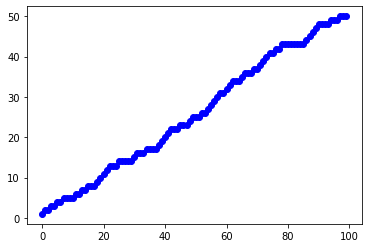

In [ ]:
plt.plot(buy_trend, 'bo')
plt.show()

In [ ]:
test_score = []
for i in range(100):
  state = env()
  test_score.append(score(state, best_action))

In [ ]:
np.mean(test_score)

6.606158632153271

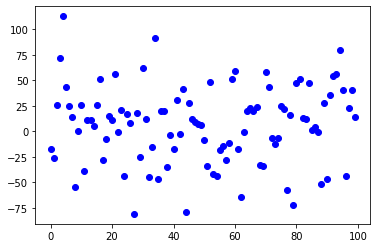

In [ ]:
plt.plot(test_score, 'bo')
plt.show()